Nutrient comparisons with edited dataset using surface instead of 2m for depth. (smelttest3)

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools, nc_tools
import pytz
import os
import glob
%matplotlib inline

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
#load model grid stuff
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)
mesh = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [4]:
# Load CitSci data and clean it up
nutrients_2015 = pd.read_excel('/home/eolson/Desktop/PSFbottledata_CN_edits_EOCor.xlsx')
Yinds = np.array([])
Xinds = np.array([])
for n in nutrients_2015.index:
    Yind, Xind = geo_tools.find_closest_model_point(nutrients_2015['lon'][n], 
                                                    nutrients_2015['lat'][n], 
                                                    X, Y, land_mask = bathy.mask)
    Yinds = np.append(Yinds, Yind)
    Xinds = np.append(Xinds, Xind)
nutrients_2015 = nutrients_2015.assign(Yind = Yinds)
nutrients_2015 = nutrients_2015.assign(Xind = Xinds)
nutrients_2015 = nutrients_2015.dropna(subset=['Yind'])

/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:170: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:171: RuntimeWarning: invalid value encountered in less
  model_lons < lon + tols[grid]['tol_lon'])),
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:172: RuntimeWarning: invalid value encountered in greater
  (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
/data/vdo/MEOPAR/tools/SalishSeaTools/salishsea_tools/geo_tools.py:173: RuntimeWarning: invalid value encountered in less
  model_lats < lat + tols[grid]['tol_lat']))


In [5]:
nutrients_2015.shape

(894, 12)

In [6]:
# load model data and load it into arrays
model_nutrients = sorted(glob.glob(
    '/ocean/vdo/MEOPAR/completed-runs/smelt3/test*/SalishSea*1d*ptrc*'))

In [7]:
with nc_tools.scDataset(model_nutrients) as f: #takes a while to run, prone to killing kernal
    times = f.variables['time_counter'][:]
    print('times is done')
    model_si = f.variables['silicon'][:, :19, ...]
    print('Si is done')
    model_n023 = f.variables['nitrate'][:, :19, ...]
    print('Nitrate is done')

times is done
Si is done
Nitrate is done


In [8]:
h = nc.Dataset(model_nutrients[0])

In [9]:
# convert into datetime
converted_timesa = nc.num2date(times, h.variables['time_counter'].units)

In [10]:
# mask everything outside of daterange of modelled results 
# apply same mask to everything in CS data
dates = nutrients_2015['date'].values
dates = np.array([pd.to_datetime(dates[n]) for n in range(894)])
dates = np.ma.masked_outside(dates, datetime.datetime(2015,1,31), datetime.datetime(2015,5,2))
Yinds = np.ma.masked_array(nutrients_2015['Yind'].values, mask = dates.mask)
Xinds = np.ma.masked_array(nutrients_2015['Xind'].values, mask = dates.mask)
depths = np.ma.masked_array(nutrients_2015['depth'].values, mask = dates.mask)
cs_si = np.ma.masked_array(nutrients_2015['si'].values, mask = dates.mask)
cs_no23 = np.ma.masked_array(nutrients_2015['no23'].values, mask = dates.mask)

In [11]:
np.ma.count(cs_si)

314

In [12]:
list_of_model_si = np.ma.masked_array(np.zeros((894)), mask = True)
list_of_model_ni = np.ma.masked_array(np.zeros((894)), mask = True)
t = 0
for n in range(894):
    if dates.mask[n] == False:
        Yind = Yinds[n]
        Xind = Xinds[n]
        date = dates[n]
        if ((depths[n] == 20) and (mesh.variables['tmask'][0,18,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 18,Yind, Xind]
            n_val = model_n023[index, 18, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
        if ((depths[n] == 2) and (mesh.variables['tmask'][0,0,Yind,Xind] == 1)):
            index = np.argmin(np.abs(converted_timesa - date))
            s_val = model_si[index, 0,Yind, Xind]
            n_val = model_n023[index, 0, Yind, Xind]
            list_of_model_si.mask[t] = False
            list_of_model_si[t] = s_val
            list_of_model_ni.mask[t] = False
            list_of_model_ni[t] = n_val
    t = t + 1

/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/vdo/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
cs_no23.mask = list_of_model_ni.mask
cs_si.mask = list_of_model_si.mask

In [14]:
np.ma.count(cs_no23)

308

bias =  0.477182087997
RMSE = 4.25898965114
Willmott = 0.83031266083


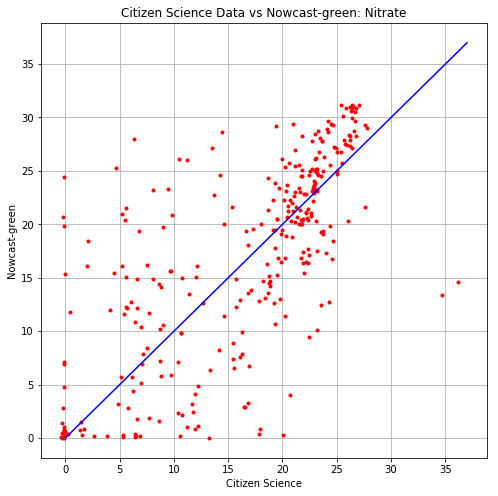

In [15]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_no23, list_of_model_ni, 'r.')
ax.plot(np.arange(0,38), np.arange(0,38), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Nitrate')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_no23) + np.mean(list_of_model_ni)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_ni - cs_no23)**2) /
                              807)))
xbar = np.mean(cs_no23)
print('Willmott = ' + str(1-(np.sum((list_of_model_ni - cs_no23)**2)  / 
                             np.sum((np.abs(list_of_model_ni - xbar) 
                                     + np.abs(cs_no23 - xbar))**2))))

bias =  -0.153814692683
RMSE = 10.1094674728
Willmott = 0.631090578376


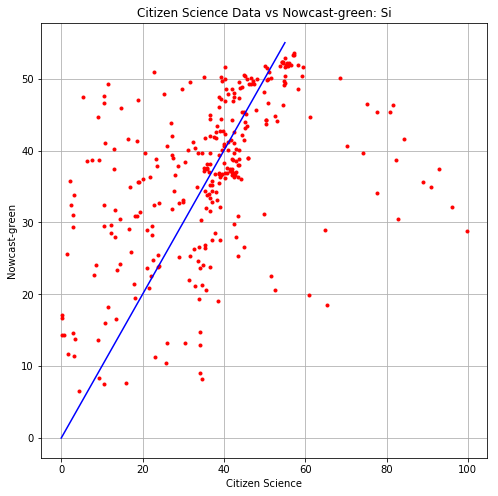

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(cs_si, list_of_model_si, 'r.')
ax.plot(np.arange(0,56), np.arange(0,56), 'b-')
ax.grid('on')
ax.set_title('Citizen Science Data vs Nowcast-green: Si')
ax.set_xlabel('Citizen Science')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(cs_si) + np.mean(list_of_model_si)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_si - cs_si)**2) /
                              807)))
xbar = np.mean(cs_si)
print('Willmott = ' + str(1-(np.sum((list_of_model_si - cs_si)**2)  / 
                             np.sum((np.abs(list_of_model_si - xbar) 
                                     + np.abs(cs_si - xbar))**2))))

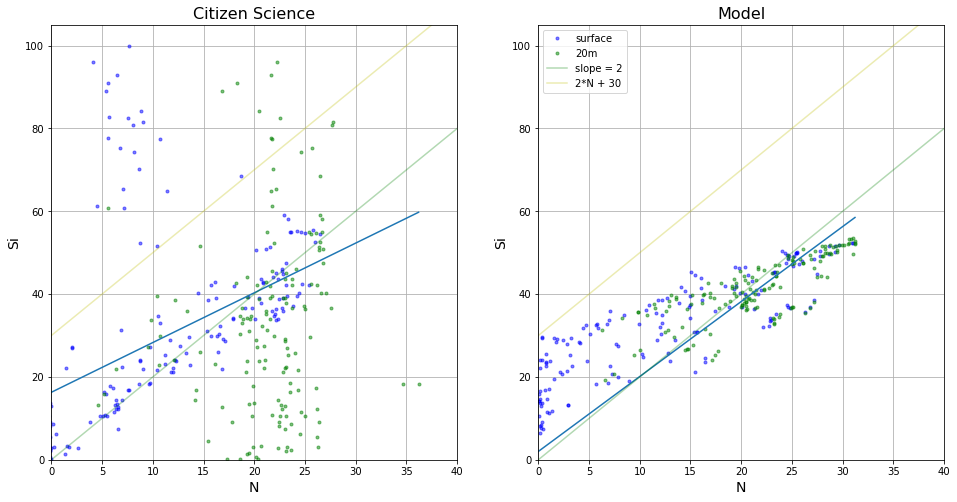

In [17]:
fig, ax = plt.subplots(1,2, figsize = (16,8))
ax[0].plot(cs_no23[nutrients_2015['depth'].values == 2], cs_si[nutrients_2015['depth'].values == 2], 
           'b.', alpha = 0.5)
ax[0].plot(cs_no23[nutrients_2015['depth'].values == 20], cs_si[nutrients_2015['depth'].values == 2], 
           'g.', alpha = 0.5)
ax[0].plot(np.unique(cs_no23), np.poly1d(np.polyfit(cs_no23, cs_si, 1))(np.unique(cs_no23)))
x = np.arange(0,50)
#ax[0].plot(x,x, 'r-', alpha = 0.3)
ax[0].plot(x, 2*x, 'g-', alpha = 0.3)
ax[0].plot(x, 2*x+30, 'y-', alpha = 0.3)
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 2], 
           list_of_model_si[nutrients_2015['depth'].values == 2], 'b.', 
           alpha = 0.5, label = 'surface')
ax[1].plot(list_of_model_ni[nutrients_2015['depth'].values == 20], 
           list_of_model_si[nutrients_2015['depth'].values == 20], 'g.', 
           alpha = 0.5, label = '20m')
ax[1].plot(np.unique(list_of_model_ni), 
           np.poly1d(np.polyfit(list_of_model_ni, list_of_model_si, 1))(np.unique(list_of_model_ni)))
x = np.arange(0,53)
#ax[1].plot(x,x, 'r-', alpha = 0.3, label = 'slope = 1')
ax[1].plot(x, 2*x, 'g-', alpha = 0.3, label = 'slope = 2')
ax[1].plot(x, 2*x+30, 'y-', alpha = 0.3, label = '2*N + 30')
ax[0].set_title('Citizen Science', fontsize = 16)
ax[1].set_title('Model', fontsize = 16)
for ax in ax:
    ax.grid('on')
    ax.set_ylabel('Si', fontsize = 14)
    ax.set_xlabel('N', fontsize = 14)
    ax.set_ylim(0,105)
    ax.set_xlim(0,40)
plt.legend();

In [18]:
m1, b1 = np.polyfit(cs_no23, cs_si, 1)
print('CitSci slope = ' + str(m1))
print('CitSci y int = ' + str(b1))
m2, b2 = np.polyfit(list_of_model_ni, list_of_model_si, 1)
print('model slope = ' + str(m2))
print('model y int = ' + str(b2))

CitSci slope = 1.20081121919
CitSci y int = 16.2994839487
model slope = 1.81002241093
model y int = 2.01396893055
